<a href="https://colab.research.google.com/github/NikolValerie/homework/blob/main/08_01_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 8 • Понедельник
## Нейронные сети
### 🔥 PyTorch

In [ ]:
!pip install torchutils

In [ ]:
!pip install mplcyberpunk

In [ ]:
!pip install category-encoders

In [ ]:
import torch
torch.manual_seed(42)
from torch import nn

from torch import optim

from torch.utils.data import TensorDataset, DataLoader, random_split

import torchutils as tu
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import numpy as np
import pandas as pd

In [ ]:
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.compose import make_column_selector
from category_encoders.target_encoder import TargetEncoder

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score


### Оценка стоимости недвижимости с применением нейронных сетей

Загрузите датасет House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) с прошлой недели: датасет должен быть предобработанный:

* в нем должны отсутствовать пропуски
* данные **обязательно** должны быть нормализованы
* целевая переменная должна быть логарифмирована
* в `TensorDataset` передаем только массив, а не `DataFrame`

In [ ]:
train = pd.read_csv('/train.csv')

In [ ]:
cat_cols = train.select_dtypes(include='object').columns.to_list()
num_cols = train.select_dtypes(include=['float64', 'int64']).columns.to_list()

drop_features = ['Id','Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature','LandSlope','GarageQual','GarageCond','MiscVal','Utilities','YrSold']
my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=['float64', 'int64'])),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include='object'))
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)
filled_data = my_imputer.fit_transform(train)

class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, train, y=None):
        self.most_common_values = {}
        for col in train.columns:
            self.most_common_values[col] = train[col].value_counts().idxmax()
        return self

    def transform(self, train):
        X_copy = train.copy()
        for col in train.columns:
            X_copy[col] = X_copy[col].replace(['Oth', 'Othr', 'Other'], self.most_common_values[col])
        return X_copy

custom_imputer = CustomImputer()
updated_data = custom_imputer.fit_transform(filled_data)

scaler_and_encoder = ColumnTransformer(
    [
        ('target_encoding', TargetEncoder(), make_column_selector(dtype_include='object')),
        ('scaling_num_columns', StandardScaler(), make_column_selector(dtype_include=['float64', 'int64']))
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

scaler_for_obj = ColumnTransformer(
    [
        ('scaling_for_obj', StandardScaler(), make_column_selector(dtype_include=['float64', 'int64']))
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('replacing_othr', custom_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('scaling_for_obj', scaler_for_obj)
    ]
)

In [ ]:
X, y = train.drop('SalePrice', axis=1), train['SalePrice']
X = preprocessor.fit_transform(X, y)
X = X.iloc[:, :].values
y = np.log(np.array(y))
n_features = X.shape[1]
print(X.shape, y.shape)
print(n_features)

(1460, 80) (1460,)
80


1. С использованием библиотеки `pytorch` задай нейронную сеть по следующей схеме:
    * На первом слое 128 нейронов с активацией `relu`
    * На втором слое 64 нейрона с активацией `relu`
    * На третьем слое дропаут с аргументом 0.5
    * Выходной слой из 1 нейрона

![](aux/baseline.png)

In [ ]:
model = nn.Sequential(
    nn.Linear(n_features,1),
    nn.ReLU()
)

tu.get_model_summary(model, torch.randn(90, n_features))

Layer   Kernel    Output    Params    FLOPs
0_0     [80, 1]   [90, 1]       81   14,310
1_1           -   [90, 1]        0        0
Total params: 81
Trainable params: 81
Non-trainable params: 0
Total FLOPs: 14,310 / 14.31 KFLOPs
-------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.03


2. Вызови `tu.get_model_summary` модели

In [ ]:
dataset = TensorDataset(torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float))

3. Импортируй `TensorDataset` и `DataLoader` и создай датасет для обучения модели.

In [ ]:
train_ds, valid_ds = random_split(dataset, lengths=(.7, .3))
train_loader = DataLoader(train_ds, shuffle=True, batch_size=128)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=128)

In [ ]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0637, -0.0438,  0.0367, -0.0630,  0.0666,  0.0187,  0.0967,  0.0933,
         -0.0461,  0.0620,  0.0129,  0.0427,  0.0288,  0.0153,  0.0034,  0.0152,
         -0.1028, -0.0654,  0.0059, -0.0435,  0.0204, -0.0333,  0.0203,  0.0780,
          0.0400,  0.0668, -0.0671,  0.0056, -0.0978,  0.0450, -0.1003,  0.0597,
          0.0258,  0.0039,  0.0209,  0.0338,  0.0889, -0.0668, -0.0692, -0.0364,
         -0.1084, -0.0208, -0.0731,  0.0037,  0.0081,  0.0878, -0.0556, -0.1058,
          0.0261,  0.0242, -0.0948,  0.0207,  0.1042, -0.0935, -0.0844,  0.0020,
          0.0625,  0.0941, -0.0627, -0.1077,  0.0426, -0.0353, -0.0070, -0.0992,
         -0.0660, -0.0384, -0.0739,  0.0045, -0.0388,  0.0668,  0.0633,  0.0426,
          0.0846, -0.0953, -0.0527, -0.0254,  0.1057,  0.0934, -0.0106, -0.0112]],
       requires_grad=True)
Parameter containing:
tensor([-0.0794], requires_grad=True)


4. Запусти обучение на 10 эпох и нарисуй кривые обучения и кривые изменения метрик. Не забудь переводить модель в режимы `train` и `eval`.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
def fit_model(model: torch.nn.modules.container.Sequential, n_epochs: int) -> tuple:

    train_losses = []
    valid_losses = []

    train_metric = []
    valid_metric = []

    for epoch in range(n_epochs):
        model.train()

        train_loss_iter = []
        train_metric_iter = []

        for samples, labels in train_loader:

            predictions = model(samples)
            predictions = predictions.squeeze(-1)
            loss = criterion(predictions, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_iter.append(loss.item())

            mse = ((predictions - labels) ** 2).mean()
            rmse = torch.sqrt(mse)
            train_metric_iter.append(rmse.item())

        ###### ВАЛИДАЦИЯ ######
        model.eval()

        valid_loss_iter = []
        valid_metric_iter = []

        for samples, labels in valid_loader:
            with torch.inference_mode():
                predictions = model(samples)

            predictions = predictions.squeeze(-1)

            loss = criterion(predictions, labels)

            valid_loss_iter.append(loss.item())

            RMSE = torch.sqrt(torch.mean((labels - predictions) ** 2))
            valid_metric_iter.append(RMSE.detach().numpy())


        # после окончания эпохи запишем все усредненные характеристики в переменные
        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))

        train_metric.append(np.mean(train_metric_iter))
        valid_metric.append(np.mean(valid_metric_iter))

        if epoch % 1 == 0:
            print(f'Epoch {epoch} finished: train_loss={train_losses[-1]:.3f}, valid_loss={valid_losses[-1]:.3f}')

    return train_losses, valid_losses, train_metric, valid_metric

In [ ]:
train_losses, valid_losses, train_metric, valid_metric = fit_model(model, 20)

Epoch 0 finished: train_loss=137.905, valid_loss=125.348
Epoch 1 finished: train_loss=117.056, valid_loss=107.183
Epoch 2 finished: train_loss=99.350, valid_loss=91.822
Epoch 3 finished: train_loss=84.459, valid_loss=78.961
Epoch 4 finished: train_loss=71.737, valid_loss=67.845
Epoch 5 finished: train_loss=61.049, valid_loss=57.941
Epoch 6 finished: train_loss=51.955, valid_loss=50.084
Epoch 7 finished: train_loss=44.239, valid_loss=43.113
Epoch 8 finished: train_loss=37.645, valid_loss=36.484
Epoch 9 finished: train_loss=32.023, valid_loss=31.359
Epoch 10 finished: train_loss=27.312, valid_loss=26.975
Epoch 11 finished: train_loss=23.262, valid_loss=23.116
Epoch 12 finished: train_loss=19.829, valid_loss=19.968
Epoch 13 finished: train_loss=16.916, valid_loss=17.228
Epoch 14 finished: train_loss=14.401, valid_loss=14.758
Epoch 15 finished: train_loss=12.288, valid_loss=12.753
Epoch 16 finished: train_loss=10.489, valid_loss=11.010
Epoch 17 finished: train_loss=8.950, valid_loss=9.442


In [ ]:
def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')

    ax[1].plot(tm, label='Train rmse')
    ax[1].plot(vm, label='Valid rmse')
    ax[1].legend()
    ax[1].set_title('RMSE')

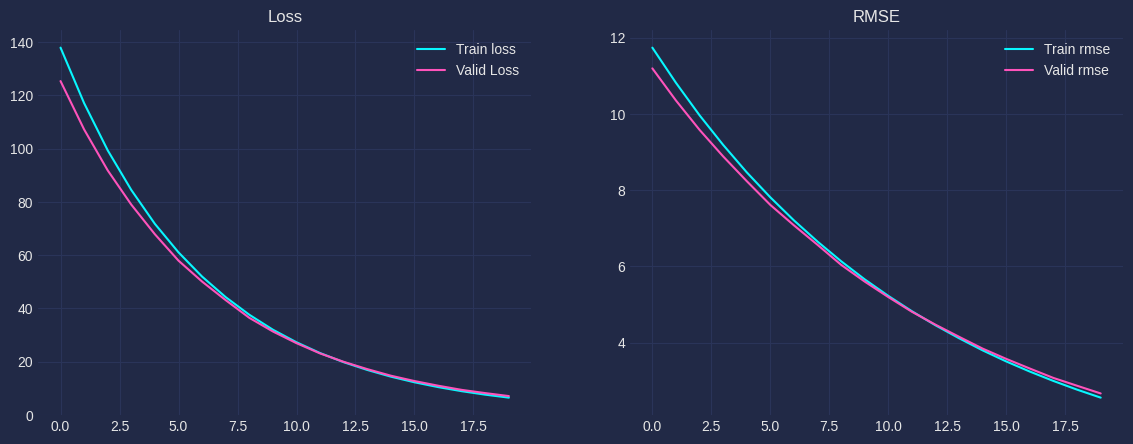

In [ ]:
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

5. Измени архитектуру модели и улучши результат:
    * измени число нейронов
    * попробуй использовать сигмоидную функцию активации: `nn.Sigmoid`
    * измени число слоев
    * поэкспериментируй с активационными функциями и дропаутом

In [ ]:
big_model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.ReLU()
)

tu.get_model_summary(big_model, torch.randn(128, n_features))

Layer    Kernel     Output     Params       FLOPs
0_0     [80, 64]   [128, 64]    5,184   1,302,528
1_1            -   [128, 64]        0           0
2_2            -   [128, 64]        0           0
3_3     [64, 16]   [128, 16]    1,040     260,096
4_4            -   [128, 16]        0           0
5_5            -   [128, 16]        0           0
6_6      [16, 1]    [128, 1]       17       3,968
7_7            -    [128, 1]        0           0
Total params: 6,241
Trainable params: 6,241
Non-trainable params: 0
Total FLOPs: 1,566,592 / 1.57 MFLOPs
-------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.24
Params size (MB): 0.02
Estimated Total Size (MB): 0.30


In [ ]:
optimizer = torch.optim.SGD(big_model.parameters(), lr=0.005)

In [ ]:
tl, vl, tm, vm = fit_model(big_model, 20)

Epoch 0 finished: train_loss=143.814, valid_loss=136.802
Epoch 1 finished: train_loss=97.148, valid_loss=24.270
Epoch 2 finished: train_loss=30.340, valid_loss=6.072
Epoch 3 finished: train_loss=21.060, valid_loss=4.582
Epoch 4 finished: train_loss=19.057, valid_loss=7.003
Epoch 5 finished: train_loss=16.587, valid_loss=4.383
Epoch 6 finished: train_loss=15.574, valid_loss=3.473
Epoch 7 finished: train_loss=14.605, valid_loss=3.405
Epoch 8 finished: train_loss=14.153, valid_loss=3.132
Epoch 9 finished: train_loss=13.241, valid_loss=3.283
Epoch 10 finished: train_loss=12.512, valid_loss=2.224
Epoch 11 finished: train_loss=12.861, valid_loss=2.538
Epoch 12 finished: train_loss=11.192, valid_loss=2.208
Epoch 13 finished: train_loss=10.837, valid_loss=1.721
Epoch 14 finished: train_loss=9.969, valid_loss=2.029
Epoch 15 finished: train_loss=10.482, valid_loss=2.533
Epoch 16 finished: train_loss=9.852, valid_loss=1.625
Epoch 17 finished: train_loss=9.791, valid_loss=1.936
Epoch 18 finished: 

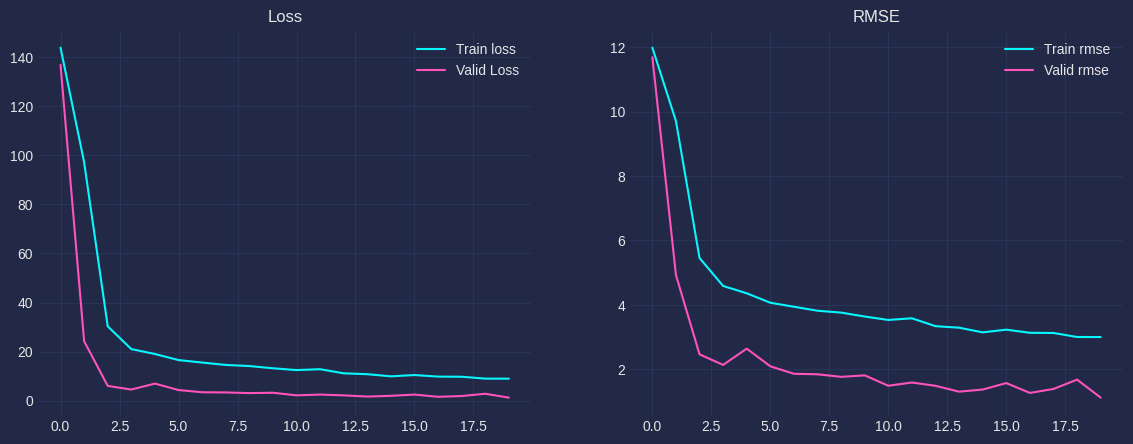

In [ ]:
plot_loss_metrics(tl, vl, tm, vm)

6. Попробуй добиться лучшего результата, чем получалось на прошлой неделе во время выполнения проекта!

## Дополнительное задание

### Классификация клиента банка

* С помощью `pytorch` классифицировать клиентов банка.

* Датасет [здесь](https://raw.githubusercontent.com/Anurion/Uralsib_test/main/Uralsib_test/Data.txt)

* Метрика: `f1_score`

* При чтении данных нужно указать аргумент `read_csv()` `encoding='kz1048'`